# Generating random fly poses from neuromechfly

* put the fly in a random pose by setting its joint angles corresponding to normal ranges of motion for locomotion
* take an image from 7 different cameras, roughly corresponding to the locations of the septacam setup
* do some image processing so these images look somewhat similar to those taken from an IR camera
* get the locations of the end of the fly's limbs from the simulation

In [1]:
# use the EGL renderering backend and select the NVIDIA GPU to speed up rendering
%env MUJOCO_GL=egl
%env MUJOCO_EGL_DEVICE_ID=0

import numpy as np
import matplotlib.pyplot as plt
import imageio
import tqdm
from pathlib import Path
import cv2
import pandas as pd
import os

from flygym import Fly, Camera, SingleFlySimulation
from flygym.state.kinematic_pose import KinematicPose
from flygym.preprogrammed import all_leg_dofs
from flygym.arena import BaseArena

legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]
dofs_per_leg = [
	"Coxa",
	"Coxa_roll",
	"Coxa_yaw",
	"Femur",
	"Femur_roll",
	"Tibia",
	"Tarsus1",
]

class EmptyArena(BaseArena):
	def __init__(
		self,
	):
		super().__init__()

	def get_spawn_position(
		self, rel_pos: np.ndarray, rel_angle: np.ndarray
	) -> tuple[np.ndarray, np.ndarray]:
		return rel_pos, rel_angle

# from https://github.com/NeLy-EPFL/sequential-inverse-kinematics/blob/alfie_loc/notebooks/adapt_ik_to_locomotion_flytracker.ipynb
BOUNDS_LOCOMOTION = {
 'RF_Coxa_yaw': (np.deg2rad(-15), np.deg2rad(30)),
 'RF_Coxa': (np.deg2rad(-40), np.deg2rad(40)),
 'RF_Coxa_roll': (np.deg2rad(-60), np.deg2rad(10)),
 'RF_Femur': (np.deg2rad(-60), np.deg2rad(10)),
 'RF_Tibia': (np.deg2rad(-10), np.deg2rad(60)),
 'RF_Femur_roll': (np.deg2rad(-180), np.deg2rad(90)),
 'RF_Tarsus1': (np.deg2rad(-60), np.deg2rad(10)),

 'RM_Coxa_yaw': (np.deg2rad(-15), np.deg2rad(30)),
 'RM_Coxa': (np.deg2rad(-40), np.deg2rad(40)),
 'RM_Coxa_roll': (np.deg2rad(-60), np.deg2rad(10)),
 'RM_Femur': (np.deg2rad(-60), np.deg2rad(10)),
 'RM_Tibia': (np.deg2rad(-10), np.deg2rad(60)),
 'RM_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RM_Tarsus1': (np.deg2rad(-60), np.deg2rad(10)),

 'RH_Coxa_yaw': (np.deg2rad(-15), np.deg2rad(30)),
 'RH_Coxa': (np.deg2rad(-40), np.deg2rad(40)),
 'RH_Coxa_roll': (np.deg2rad(-60), np.deg2rad(10)),
 'RH_Femur': (np.deg2rad(-60), np.deg2rad(10)),
 'RH_Tibia': (np.deg2rad(-10), np.deg2rad(60)),
 'RH_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RH_Tarsus1': (np.deg2rad(-60), np.deg2rad(10)),

 'LF_Coxa_yaw': (np.deg2rad(-15), np.deg2rad(30)),
 'LF_Coxa': (np.deg2rad(-40), np.deg2rad(40)),
 'LF_Coxa_roll': (np.deg2rad(-60), np.deg2rad(90)),
 'LF_Femur': (np.deg2rad(-60), np.deg2rad(10)),
 'LF_Tibia': (np.deg2rad(-10), np.deg2rad(60)),
 'LF_Femur_roll': (np.deg2rad(-90), np.deg2rad(180)),
 'LF_Tarsus1': (np.deg2rad(-60), np.deg2rad(10)),

 'LM_Coxa_yaw': (np.deg2rad(-15), np.deg2rad(30)),
 'LM_Coxa': (np.deg2rad(-40), np.deg2rad(40)),
 'LM_Coxa_roll': (np.deg2rad(-60), np.deg2rad(180)),
 'LM_Femur': (np.deg2rad(-60), np.deg2rad(10)),
 'LM_Tibia': (np.deg2rad(-10), np.deg2rad(60)),
 'LM_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LM_Tarsus1': (np.deg2rad(-60), np.deg2rad(10)),

 'LH_Coxa_yaw': (np.deg2rad(-15), np.deg2rad(30)),
 'LH_Coxa': (np.deg2rad(-40), np.deg2rad(40)),
 'LH_Coxa_roll': (np.deg2rad(-60), np.deg2rad(180)),
 'LH_Femur': (np.deg2rad(-60), np.deg2rad(10)),
 'LH_Tibia': (np.deg2rad(-10), np.deg2rad(60)),
 'LH_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LH_Tarsus1': (np.deg2rad(-60), np.deg2rad(10))
}

JOINT_COLOURS = np.array([
	[15, 115, 153], # LF
	[26, 141, 175], # LM
	[117, 190, 203], # LH
	[186, 30, 49], # RF
	[201, 86, 79], # RM
	[213, 133, 121], # RH
]) / 255

env: MUJOCO_GL=egl
env: MUJOCO_EGL_DEVICE_ID=0


In [2]:
def rand_in_range(min: float, max: float):
	return np.random.random()*(max-min) + min

def hide_points_outside_image(points: np.ndarray, image_size: tuple[int, ...]):
	"""Sets all points not within the bounds of an image size to NaN.

	- `points`: a [..., 2] array of (x,y) points within the image - ie. there can be many dimensions but the last one is of size 2
	- `image_size`: size of the image (height, width)
	"""
	points[(points[..., 0] < 0) | (points[..., 1] < 0) | (points[..., 0] > image_size[1]) | (points[..., 1] > image_size[0])] = np.nan
	return points

def hide_points_that_camera_cant_see(points: np.ndarray, camera_num: int):
	"""points - [num_legs * num_joints_per_leg * 2]"""
	if camera_num < 3: # camera sees the left side of the body
		points[3:] = np.nan
	elif camera_num > 3: # camera sees the right side of the body
		points[:3] = np.nan
	else: # camera in the middle sees the front two sets of legs
		points[(2,5),:] = np.nan
	return points

def show_images(images: list[np.ndarray]):
	plt.figure(figsize=(30,10))
	plt.imshow(np.hstack(images), cmap='gray')
	plt.show()

def draw_skeleton_points(points: np.ndarray, offset: tuple[float,float]):
	"""points - [num_legs * num_joints_per_leg * 2]"""
	plt.gca().set_prop_cycle('color', JOINT_COLOURS)
	plt.plot(points[:,:,0].T + offset[0], points[:,:,1].T + offset[1], "-o")

def show_images_with_points(images: list[np.ndarray], points: list[np.ndarray]):
	"""points: positions of joints in images - list: [num_legs, num_points_per_leg, 2]*num_cameras"""
	plt.figure(figsize=(30,10))
	plt.imshow(np.hstack(images), cmap='gray')
	for camera_num, cam_points in enumerate(points):
		cam_points = hide_points_that_camera_cant_see(hide_points_outside_image(cam_points, images[0].shape), camera_num)
		draw_skeleton_points(cam_points, offset=(camera_num*images[0].shape[1], 0))
	plt.show()

def filter_image_to_greyscale(image: np.ndarray):
	"""Apply a filter so the image looks somewhat like it was taken from an IR camera."""
	return np.power(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1).clip(0,255).astype(np.uint8)

def set_fly_rand_pose(sim: SingleFlySimulation):
	pose = KinematicPose({
		f"joint_{leg}{dof}": rand_in_range(*BOUNDS_LOCOMOTION[f"{leg}_{dof}"])
		for leg in legs
		for dof in dofs_per_leg
	})
	# without resetting the context the pose of the fly doesn't get updated
	with sim.physics.reset_context():
		sim.fly.set_pose(pose, sim.physics)

def get_camera_images(sim: SingleFlySimulation) -> list[np.ndarray]:
	# we can directly call the mujoco camera's render method
	frames = [
		filter_image_to_greyscale(cam.dm_camera.render())
		for cam in sim.cameras
	]
	return frames

def project_3d_points_to_cameras(sim: SingleFlySimulation, points3d: np.ndarray):
	"""Returns 2d points in image space - shape [2, N]"""
	points_list = []
	for cam in sim.cameras:
		# pad with ones to convert to homogeneous coordinates
		points_homogeneous = np.vstack((
			points3d,
			np.ones((1,points3d.shape[1]))
		))
		# project the 3d positions onto the camera
		points2d = cam.dm_camera.matrix @ points_homogeneous
		# normalise by the z image coordinate
		points2d = points2d[:2] / points2d[2].reshape(1,-1)
		points_list.append(points2d)
	return points_list

def get_end_effector_positions_in_cameras(sim: SingleFlySimulation) -> list[np.ndarray]:
	"""Get the 2d positions of the end effectors as a list of 2x6 numpy arrays, one for each camera."""
	return project_3d_points_to_cameras(sim, sim.fly.get_observation(sim)['end_effectors'].T)

def get_joints_pos(sim: SingleFlySimulation, joint_pos_sensors):
	"""Returns positions of joints in images - list: [num_legs, num_points_per_leg, 2]*num_cameras"""
	return [points2d.T.reshape(sim.fly.n_legs, -1, 2) for points2d in project_3d_points_to_cameras(sim, sim.physics.bind(joint_pos_sensors).sensordata.copy().reshape((-1, 3)).T)]

def get_random_fly_position(sim: SingleFlySimulation, joint_pos_sensors):
	set_fly_rand_pose(sim)
	return get_camera_images(sim), get_joints_pos(sim, joint_pos_sensors)

In [3]:
# setup the fly in the 7 camera setup
fly = Fly(init_pose="stretch", actuated_joints=all_leg_dofs, control="position", xml_variant=Path("../flygym/data/mjcf/neuromechfly_seqik_kinorder_ypr_7cam.xml"))

joint_pos_sensors = [
	fly.model.sensor.add(
		"framepos",
		name=f"{side}{leg}{joint}_pos",
		objtype="xbody",
		objname=f"{side}{leg}{joint}",
	)
	for side in "LR"
	for leg in "FMH"
	for joint in ["Coxa","Femur","Tibia","Tarsus1"]
]
for index,end_effector_sensor in zip(range(len(joint_pos_sensors), 0, -4), fly._end_effector_sensors[::-1]):
	joint_pos_sensors.insert(index, end_effector_sensor)

cams = [
	Camera(fly=fly, camera_id=f"Animat/camera_{camera}", window_size=(960,640), play_speed=0.1, draw_contacts=False)
	for camera in range(7)
]
sim = SingleFlySimulation(fly=fly, cameras=cams, arena=EmptyArena(), timestep=1e-4, gravity=(0,0,0))

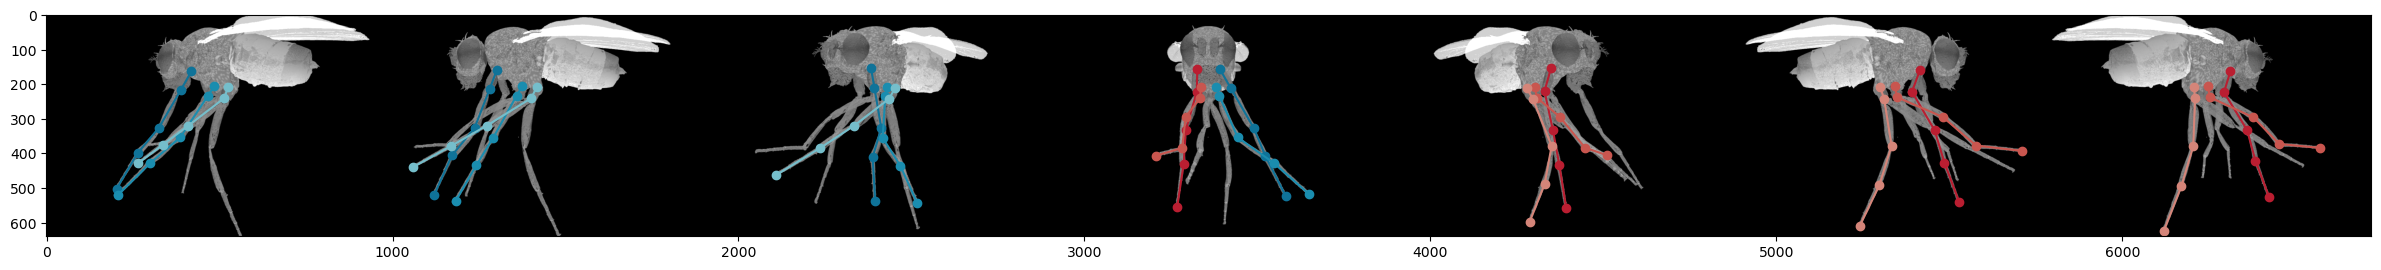

In [4]:
# check that we can get the fly in a random pose
show_images_with_points(*get_random_fly_position(sim, joint_pos_sensors))

In [5]:
LABELLER = "DD"

def save_frames_to_video(frames: list[list[np.ndarray]], output_dir: Path):
	for camera_num in range(len(frames[0])):
		with imageio.get_writer(output_dir / f"camera_{camera_num}.mp4") as writer:
			for frame_num in range(len(frames)):
				writer.append_data(frames[frame_num][camera_num])

def save_frames(frames: list[list[np.ndarray]], output_dir: Path):
	for frame_num in range(len(frames)):
		for camera_num in range(len(frames[0])):
			with imageio.get_writer(output_dir / f"camera_{camera_num}" / f"image_{frame_num}.png") as writer:
				writer.append_data(frames[frame_num][camera_num])

def points_to_deeplabcut_format(joint_locations: list[list[np.ndarray]]):
	"""Convert the points from each of the cameras into a dataframe that matches the deeplabcut format"""
	num_frames = len(joint_locations)
	num_cameras = len(joint_locations[0])
	joints = [
		f"{side}{leg}{joint}"
		for side in "LR"
		for leg in "FMH"
		for joint in ["Thorax-Coxa","Coxa-Femur","Femur-Tibia","Tibia-Tarsus","Tarsus-Claw"]
	]
	# have data as frames * cameras * leg * joints_per_leg * (x,y), but want it as cameras * frames * leg * joints_per_leg * (x,y)
	df = pd.DataFrame(np.array(joint_locations).transpose(1,0,2,3,4).reshape(-1,len(joints)*2),
		columns=pd.MultiIndex.from_product([[LABELLER], joints, ['x','y']], names=['scorer', 'bodyparts', 'coords']), 
		index=pd.MultiIndex.from_product([['labeled-data'], [f'camera_{cam}' for cam in range(num_cameras)], [f'image_{n}.png' for n in range(num_frames)]])
	)
	return df

def save_deeplabcut(df: pd.DataFrame, output_dir: Path):
	"""Save the annotations for each camera separately."""
	for camera_name in df.index.get_level_values(1).unique():
		camera_dir = output_dir / camera_name
		df.xs(camera_name, axis=0, level=1, drop_level=False).to_hdf(camera_dir / f'CollectedData_{LABELLER}.h5', key='annotations')

In [6]:
FRAMES_TO_GENERATE = 1000

frames = []
points3d = []
for _ in tqdm.trange(FRAMES_TO_GENERATE):
	f, p = get_random_fly_position(sim, joint_pos_sensors)
	frames.append(f)
	points3d.append([hide_points_that_camera_cant_see(hide_points_outside_image(point, f[0].shape), camera_id) for camera_id, point in enumerate(p)])

100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


In [9]:
import shutil
output_dir = Path("./synthetic_data")
if os.path.exists(output_dir):
	shutil.rmtree(output_dir)
os.makedirs(output_dir)
for camera_num in range(len(sim.cameras)):
	os.makedirs(output_dir / f"camera_{camera_num}")

save_frames_to_video(frames, output_dir)
save_frames(frames, output_dir)
save_deeplabcut(points_to_deeplabcut_format(points3d), output_dir)

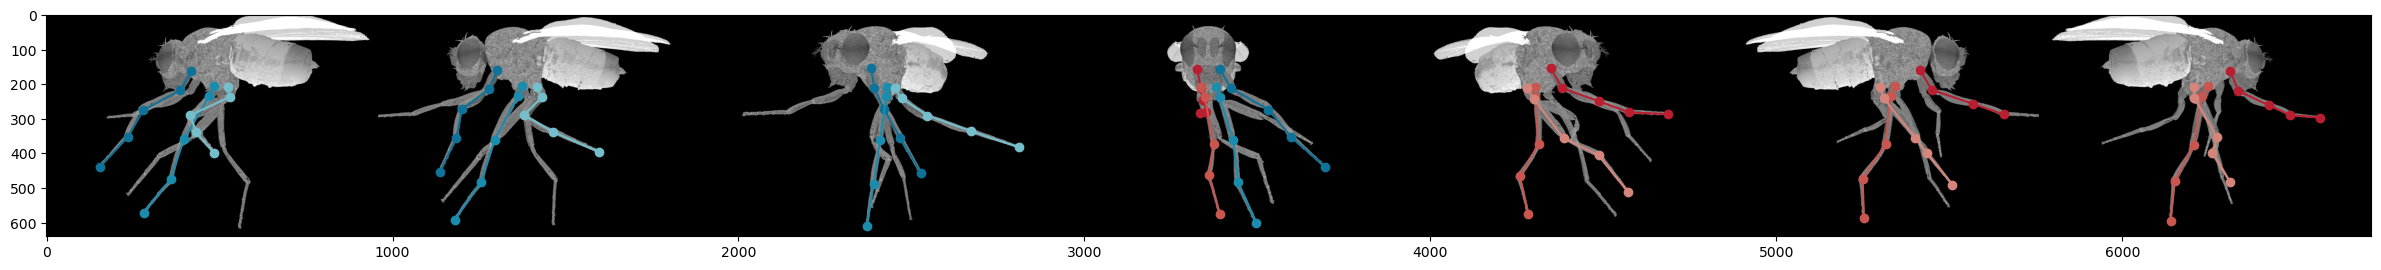

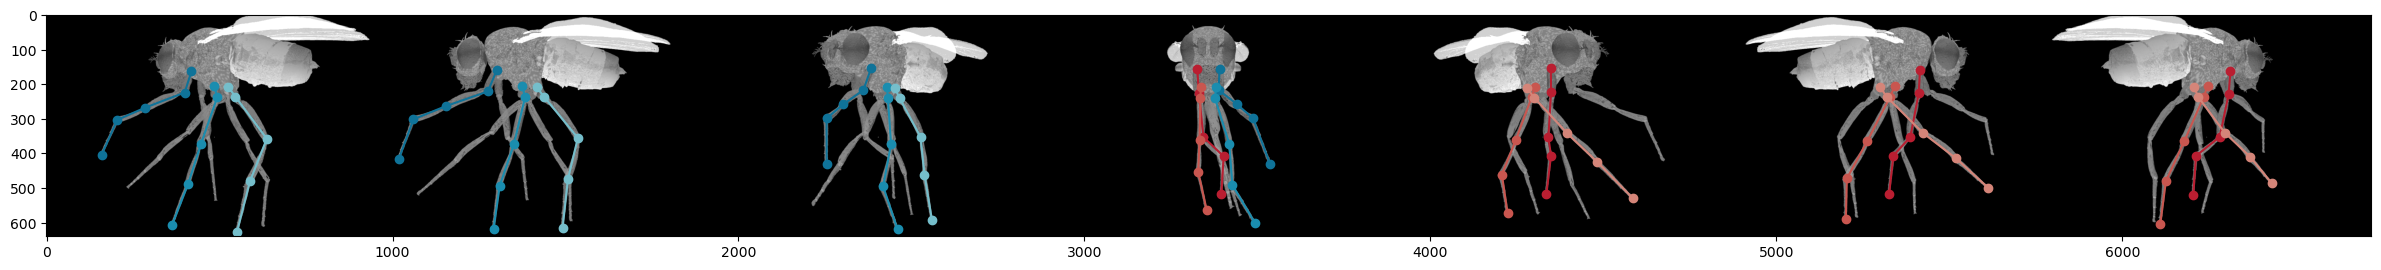

In [7]:
# sanity check the first and last frames
show_images_with_points(frames[0], points3d[0])
show_images_with_points(frames[-1], points3d[-1])

In [ ]:
# check that the DLC data looks OK
pd.read_hdf(output_dir / "camera_0/CollectedData_DD.h5")

## Plot the results from the deeplabcut training

/home/dallosto/micromamba/envs/flygym/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 180 rows containing missing values.


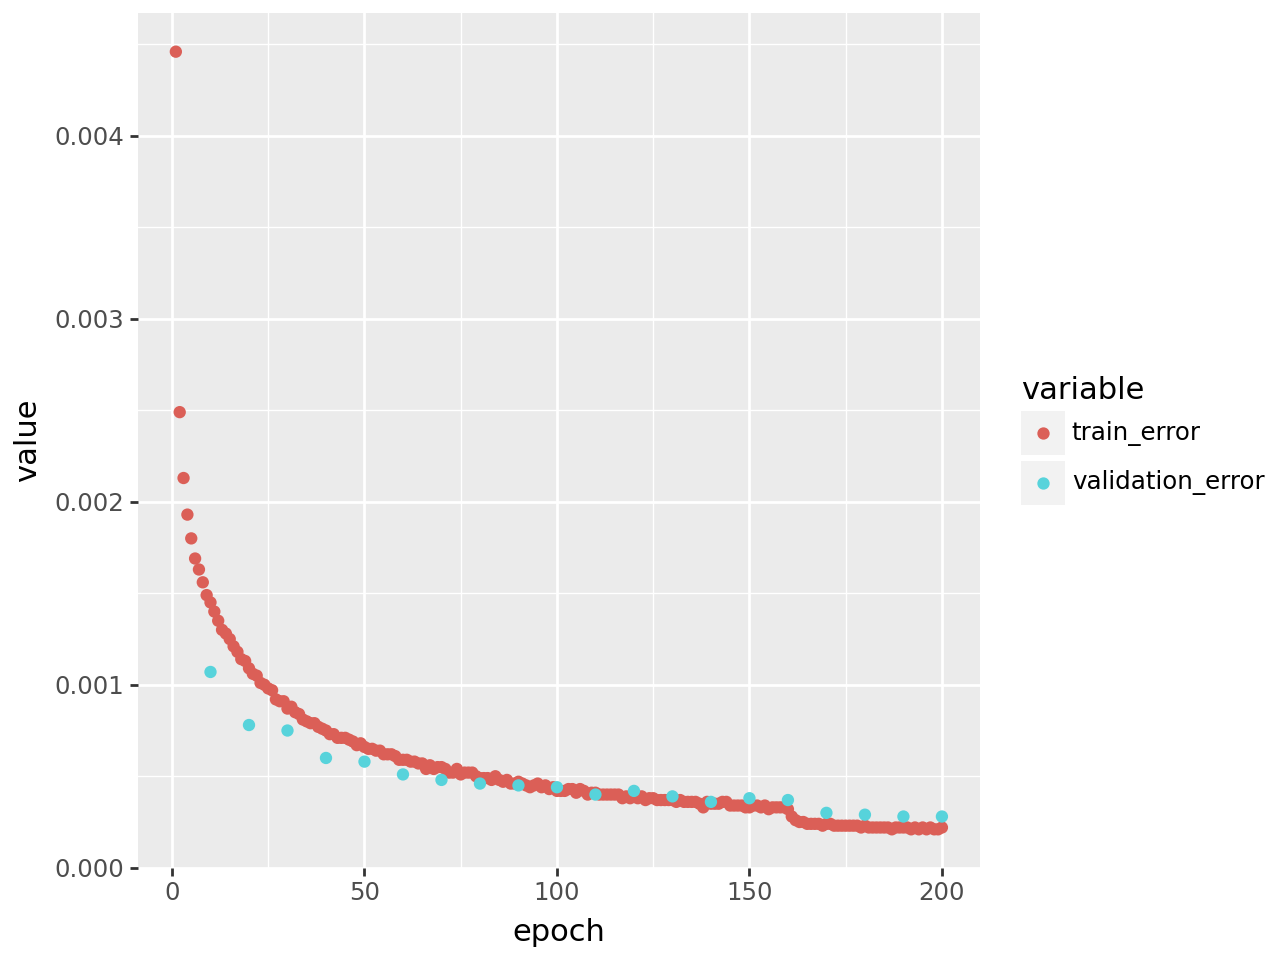

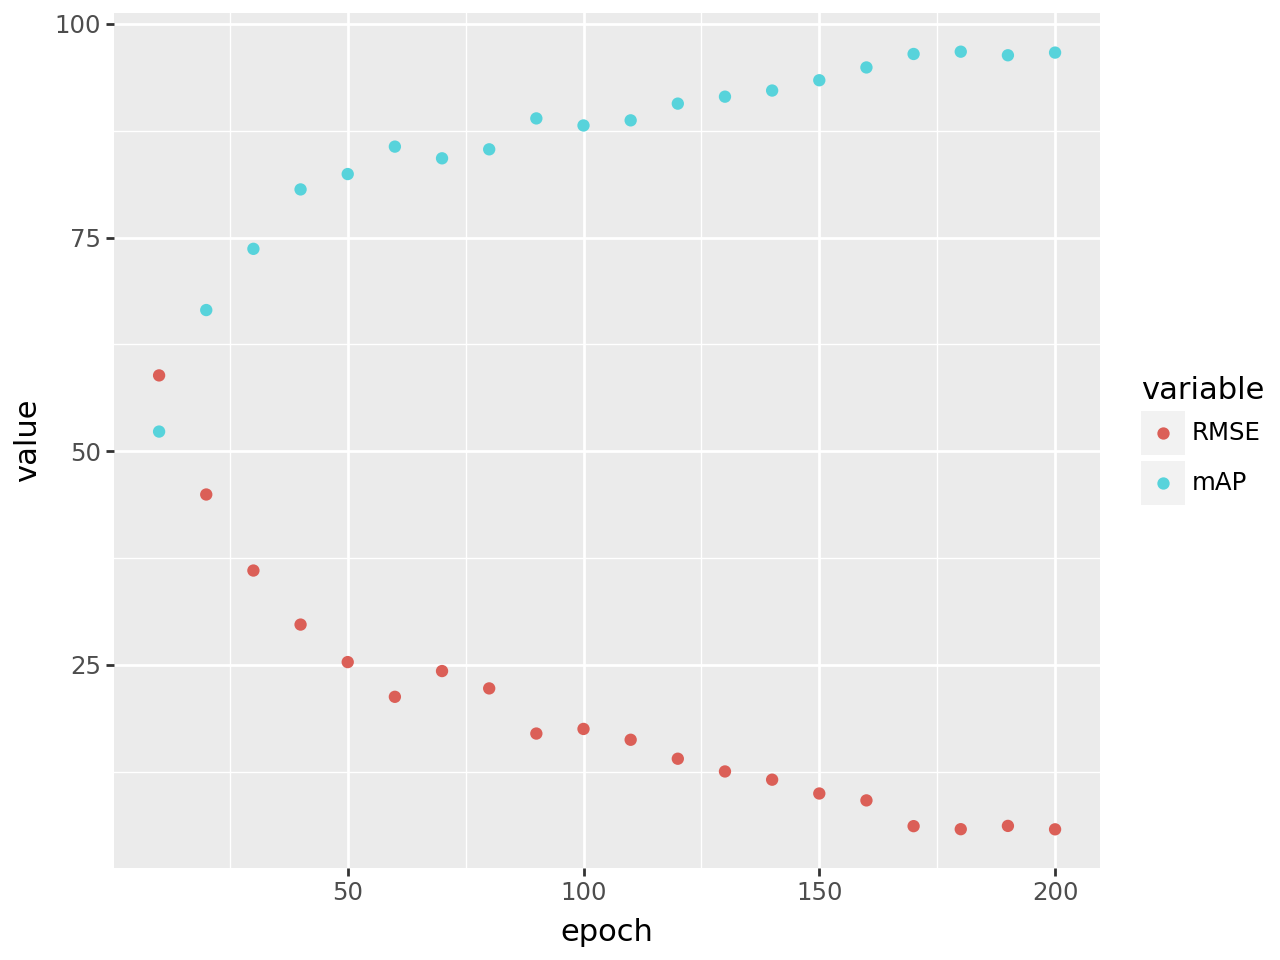

In [3]:
import re
import numpy as np
from plotnine import ggplot, aes, geom_point
import pandas as pd

lines = open("./data.txt", "r").readlines()


def get_losses():
	epoch = re.compile(r"Epoch ([\d]+)/200")
	train_loss = re.compile(r"train loss ([\d.]+)")
	valid_loss = re.compile(r"valid loss ([\d.]+)")
	return pd.DataFrame([
		[
			epoch.search(line)[1],
			train_loss.search(line)[1],
			valid_loss.search(line)[1] if valid_loss.search(line) is not None else np.nan
		]
		for line in lines
		if epoch.search(line) is not None
	], columns=['epoch','train_error','validation_error'], dtype=float)

def get_metrics():
	metrics_epoch = re.compile(r"Epoch ([\d]+) performance:")
	metrics_rmse = re.compile(r"metrics/test.rmse:\s*([\d.]+)")
	metrics_map = re.compile(r"metrics/test.mAP:\s*([\d.]+)")
	epochs = [metrics_epoch.search(line)[1] for line in lines if metrics_epoch.search(line) is not None]
	rmse = [metrics_rmse.search(line)[1] for line in lines if metrics_rmse.search(line) is not None]
	map = [metrics_map.search(line)[1] for line in lines if metrics_map.search(line) is not None]
	return pd.DataFrame({"epoch": epochs, "RMSE": rmse, "mAP": map}, dtype=float)

display(ggplot(
	get_losses().melt(['epoch'], ['train_error','validation_error'])
) + aes(x='epoch', y='value', color='variable') + geom_point())
display(ggplot(
	get_metrics().melt(['epoch'], ['RMSE','mAP'])
) + aes(x='epoch', y='value', color='variable') + geom_point())